# Project 1: Analyzing Spectroscopic data from OMM

In [318]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from astropy.utils.data import download_file
from scipy.stats import lognorm

plt.rcParams['figure.figsize'] = (12, 2)

## Part 1: Exploration

We can define a plotting function for our FITS files for repeated plotting down the line

In [319]:
#NOTE: Turn basic fits astropy file manipulations into a class
# class AstropyFits:
#     def __init__(self):
#         self.fits_file = fits_file
#
#     def convert_fits_to_data(self, ):


In [320]:
def plot_fits(data, vmin, vmax, title, norm = None):
    #plot the data...
    fig, ax = plt.subplots()
    im = ax.imshow(data, vmin=vmin, vmax=vmax, cmap='viridis', origin='lower', norm=norm, aspect='auto')
    ax.set_xlabel('x pixels')
    ax.set_ylabel('y pixels')
    ax.set_title(title)
    fig.colorbar(im)

def fits_to_data(file_name):
    source_file = fits.open(file_name)
    source_data = source_file[0].data
    return source_data, source_file


Let's produce some rough visualizations of the source file, a calibration lamp, and dark frame.

In [321]:
parent = './fit_files/'
bias = './bias/'
dark = './dark/'
flat = './flat/'
source_fits = parent + 'source.fits'
cal_lamp_fits = parent + 'calibration.fits'
bias_frame_fits = parent + bias + 'bias0008.fits'
dark_frame_fits = parent + dark + 'dark0001.fits'

In [322]:
s_data, s_file = fits_to_data(source_fits)
cal_lamp_data, cal_lamp_file = fits_to_data(cal_lamp_fits)
bias_frame_data, bias_frame_file = fits_to_data(bias_frame_fits)
dark_frame_data, dark_frame_file = fits_to_data(dark_frame_fits)

In [323]:
print((s_data.shape))

(512, 2720)


Viewing the header of the source file, we can see the source is Orion and look at other things like photometric results and observing details.

In [324]:
source_header = s_file[0].header
print(repr(source_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'orion   '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'object  '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:21:

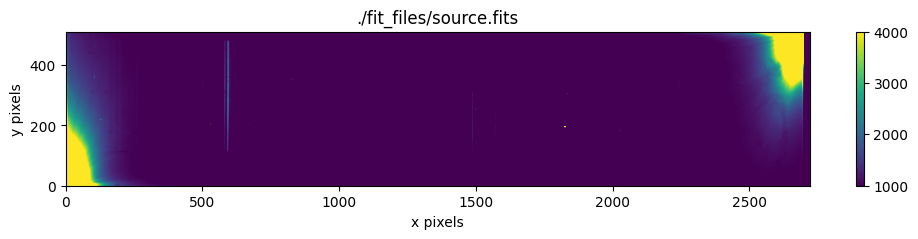

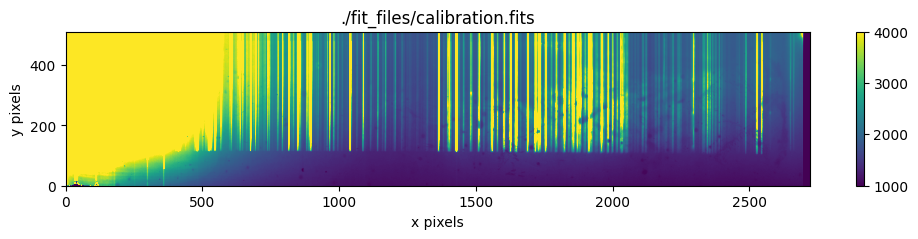

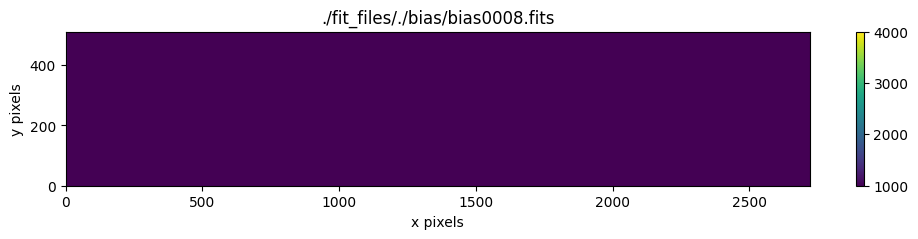

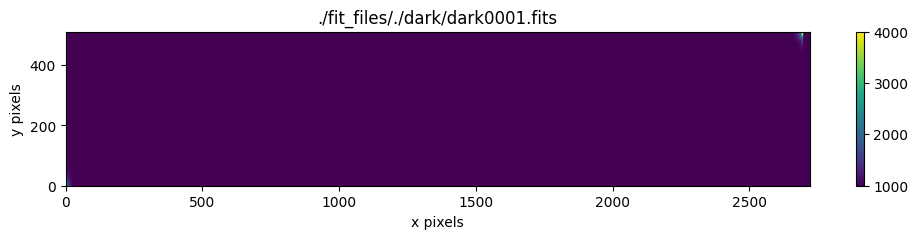

In [325]:
#Now let's plot the different images:
#we need to establish a minimum and maximum range to plot the intensity over
vmin = 1e3
vmax = 4e3

plot_fits(s_data, vmin, vmax, title=source_fits, norm=None)
plot_fits(cal_lamp_data, vmin, vmax, title=cal_lamp_fits, norm=None)
plot_fits(bias_frame_data, vmin, vmax, title=bias_frame_fits, norm=None)
plot_fits(dark_frame_data, vmin, vmax, title=dark_frame_fits, norm=None)


Let's take a look at what the 'data' files look like so we have an idea of what needs to be done algorithmically when trying to compute the PS.

In [326]:
print(type(s_data))
print(s_data)

<class 'numpy.ndarray'>
[[863 859   0 ... 848 852 856]
 [854 856   0 ... 856 847 844]
 [843 842   0 ... 838 847 841]
 ...
 [850 849   0 ... 846 849 841]
 [849 848   0 ... 849 839 850]
 [850 851   0 ... 855 841 847]]


Ok, so the data is just a 2D matrix and morever a Numpy array so we can perform all the basic math operations on it.

Text(0, 0.5, 'Total Counts')

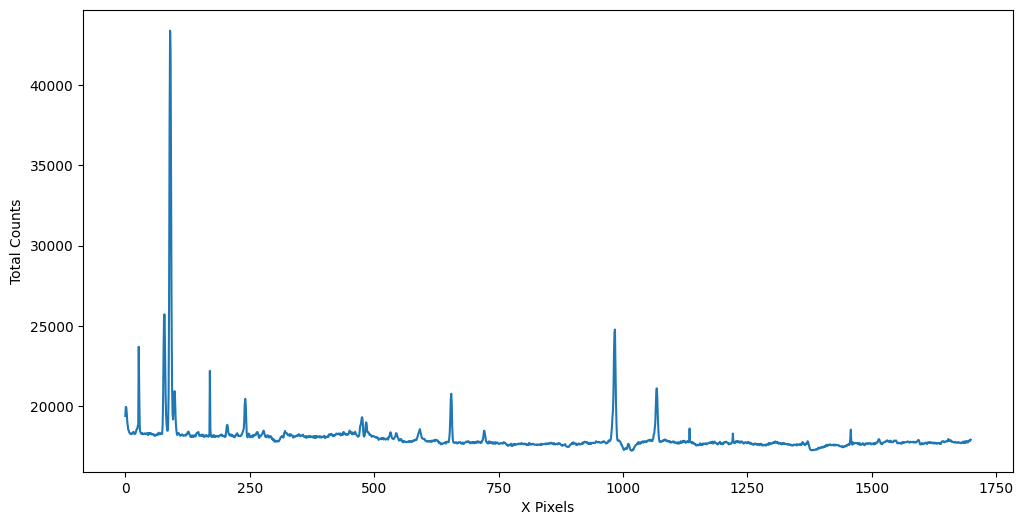

In [465]:
source_spectrum = np.sum(s_data[200:220, 500:2200], axis = 0)
# source_spectrum = np.sum(s_data[200:220], axis = 0)

plt.plot(source_spectrum)
plt.xlabel("X Pixels")
plt.ylabel("Total Counts")

## Part 2: Noise Removal

### Part 2.1 - Master bias

For the first part of the noise removal, we need to make a master bias frame. According to the project outline a ***bias*** frame is one where a minimum duration exposure was taken without significant light entering the detector. We should take a master bias frame by taking the median of all the bias frames included.

In [328]:
import os

directory = r"./fit_files/bias/"

bias_frames = []
for name in os.listdir(directory):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        # print(name)
        bias_frames.append(name)

bias_data = []
bias_files = []
for fit_file in bias_frames:
    # print(fit_file)
    file_name = directory + fit_file
    # print(file_name)
    data, file = fits_to_data(directory + str(fit_file))
    bias_data.append(data)
    bias_files.append(file)

bias_array = np.zeros((bias_data[0].shape[0], bias_data[0].shape[1], len(bias_data)))
for num, data_file in enumerate(bias_data):
    bias_array[:, :, num] = data_file

median_bias = np.median(bias_array, axis = 2)
# print(median_bias)
# print(median_bias.shape)

Now that we've computed the median bias frame, let's plot it to try and see some of the qualitative features. Plotting first and then using the colorbar to select the a smaller range seems to show a bit more features at the side of the plot.

NOTE: Will need to answer in the write up what the bias frame is trying to correct for, as well as describe in qualitatively.

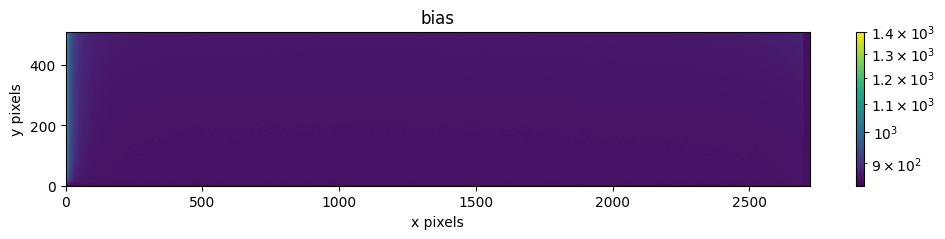

In [329]:
#define again some vmin and vmax
vmin = None
vmax = None
norm = "log"
# norm = None
plot_fits(median_bias, vmin=vmin, vmax=vmax, title="bias", norm=norm)

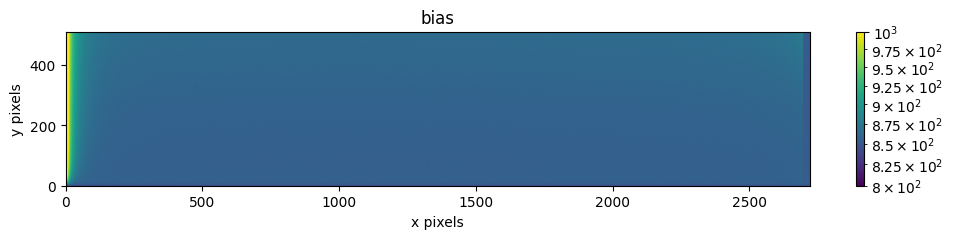

In [330]:
#define again some vmin and vmax
vmin = 800
vmax = 1000
norm = "log"
# norm = None
plot_fits(median_bias, vmin=vmin, vmax=vmax, title="bias", norm=norm)

Ok, now let's remove the bias from each of the dark, flats, calibration, and source_data, files.

In [331]:
#we have the source data file from befor it's just s_data. Unpacking the other files:
dir = r'./fit_files/dark/'
dark_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        dark_frames.append(name)
# print(dark_frames)

dark_data = []
dark_files = []
for file in dark_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    dark_data.append(data)
    dark_files.append(file)


dir = r'./fit_files/flat/'
flat_frames = []
for name in os.listdir(dir):
    flag = True
    if "Zone" in name:
        flag = False
    if flag:
        flat_frames.append(name)
# print(dark_frames)

flat_data = []
flat_files = []
for file in flat_frames:
    file_name = dir + str(file)
    data, file = fits_to_data(file_name)
    flat_data.append(data)
    flat_files.append(file)

#Now let's subtract the bias from each of the dark and flat frames and both the
# srouce and calibration (arc) data
dark_bias = []
flat_bias = []
src_bias = 0
calibration_bias = 0

#Subtract median bias from each of the dark frames
for num, dark in enumerate(dark_data):
    # print(num)
    # print(dark_data[num])
    dark_data[num] = dark_data[num] - median_bias

#Subtract median bias from each of the flat frames
for num, flat in enumerate(flat_data):
    # print(num)
    # print(dark_data[num])
    flat_data[num] = flat_data[num] - median_bias

#From the source data
source_data = s_data - median_bias

#Read in the calibration data, since we didn't do this earlier on
calibration_data, calibration_file = fits_to_data('./fit_files/calibration.fits')

#Subtract median bias from the arc file
calibration_data = calibration_data - median_bias


When Matt is talking about the arc file, he must be talking about the calibration file (taken with the arc lamp) since the alternative (plotting the cuar.fits data file) is only useful for the spectrum

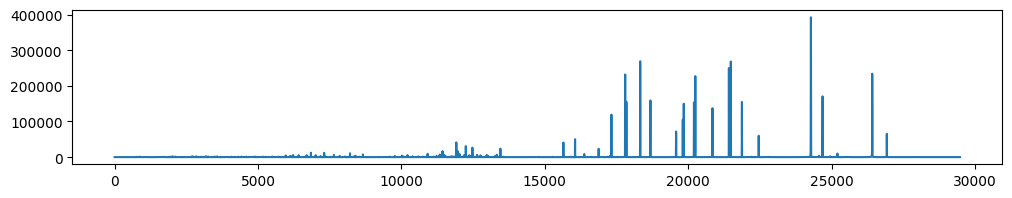

In [332]:
cuar_data, _ = fits_to_data('./fit_files/cuar.fits')
plt.plot(cuar_data)

#### Test plots for each of the flat, dark, source, and calibration files with median bias subtracted

### Part 2.2 - Master Dark

Our goal is to see which of the darks has the same exposure as the source, as this is the one we will want to subtract from the source file. Therefore, we print out the header of darks along with, again, the source file:

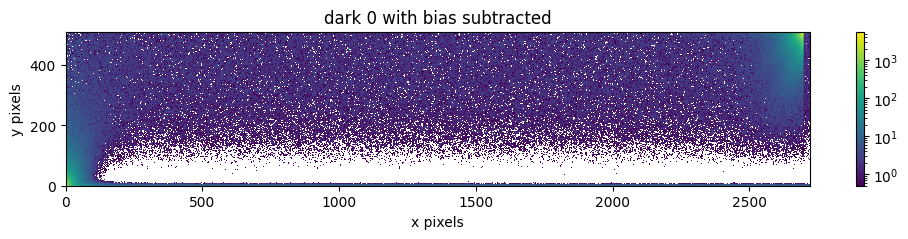

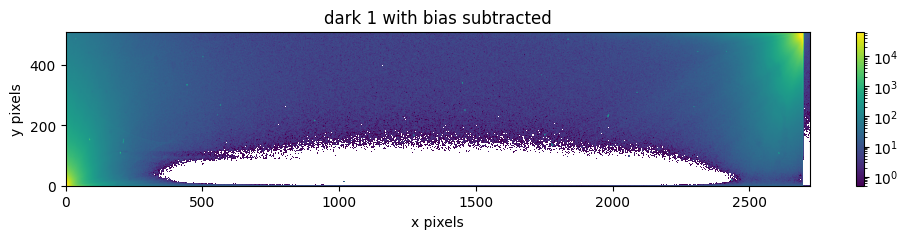

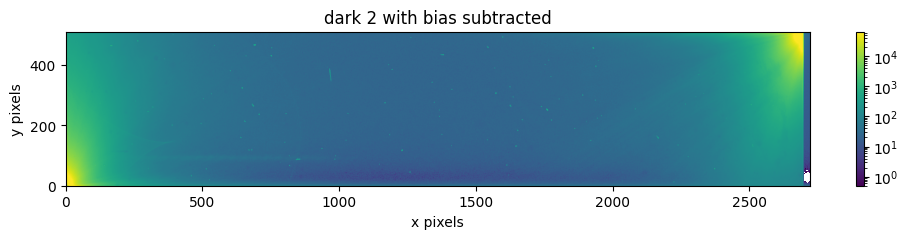

In [333]:
for i, dark_data_file in enumerate(dark_data):
    plot_fits(
        dark_data[i], vmin=None, vmax=None, title=f'dark {i} with bias subtracted', norm='log'
              )
#
# plot_fits(
#     dark_data[0], vmin=None, vmax=None, title='dark 3 with bias subtracted', norm='log'
#           )
# plot_fits(
#     dark_data[1], vmin=None, vmax=None, title='dark 3 with bias subtracted', norm='log'
#           )
# plot_fits(
#     dark_data[2], vmin=None, vmax=None, title='dark 3 with bias subtracted', norm='log'
#           )

In [334]:
#also display the headers since we care most about whichever one had the same exposure time as the source data
dark_data_header = dark_files[2][0].header
print(repr(dark_data_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'dark    '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'dark    '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T10:18:

In [335]:
 #and compare with source file header to match exposure times
print(repr(source_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'orion   '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'object  '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:21:

So, clearly dark 3 and the source have the same exposure time (it is 1800s). This is therefore the dark frame to use to dubtract from the data:

In [336]:
#subtracting the correct dark frame (number 3 ~ index num 2) from the source and calibration file
source_dark_adj = source_data - dark_data[2]
cal_dark_adj = calibration_data - dark_data[2]

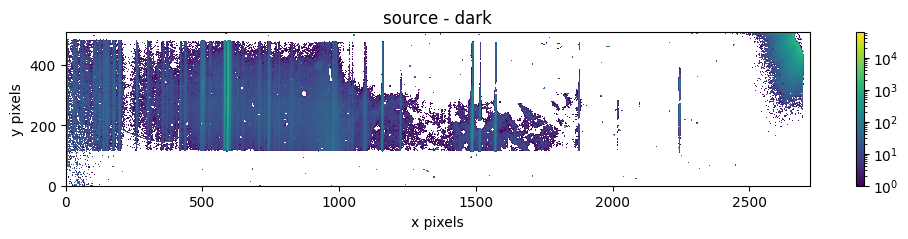

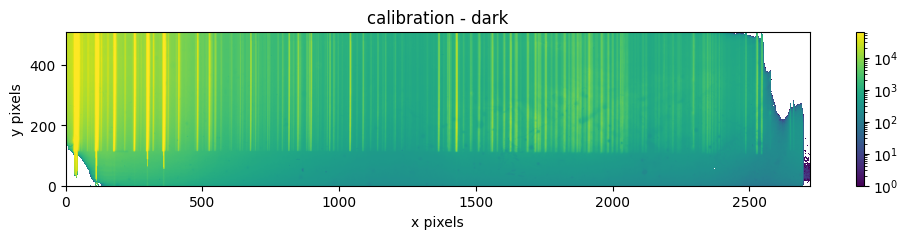

In [337]:
#and plot to to get a snapshot of how we're doing so far
plot_fits(
    source_dark_adj, vmin=None, vmax=None, title='source - dark', norm='log'
          )
plot_fits(
    cal_dark_adj, vmin=None, vmax=None, title='calibration - dark', norm='log'
          )

### Part 2.3 - Master Flat



A few of the flats

Note that we can take a look at the header to determine the max value that can be stored for a pixel. A safe thing to do is to set a saturattion value of 65535 and a 1% saturation threshold to determine the maximum amout of saturation to allow for.

In [380]:
print(repr(flat_files[0][0].header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'flat    '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =                 5.00  / Temps d'exposition (sec)                      
DARKTIME=                 5.00  / Temps total ecoule (sec)                      
IMAGETYP= 'dflat   '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T09:44:

#### Determining which flats have too much saturation

In [396]:
saturation_value = 65535 - 32768  # Maximum physical value for a 16-bit frame with BZERO=32768 (adjusted for bias subtraction)
saturation_fraction_threshold = 0.01  # e.g., 1%

good_frames = []
for idx, frame in enumerate(flat_data):
    num_saturated = np.sum(frame >= saturation_value)
    total_pixels = frame.size
    frac_saturated = num_saturated / total_pixels

    if frac_saturated <= saturation_fraction_threshold:
        good_frames.append(frame)
        print(f"Frame {idx} has sufficiently low saturation.")
    else:
        print(f"Frame {idx} rejected: {frac_saturated:.2%} pixels are saturated.")

Frame 0 has sufficiently low saturation.
Frame 1 rejected: 34.46% pixels are saturated.
Frame 2 has sufficiently low saturation.
Frame 3 has sufficiently low saturation.
Frame 4 rejected: 34.67% pixels are saturated.
Frame 5 has sufficiently low saturation.
Frame 6 rejected: 34.58% pixels are saturated.
Frame 7 rejected: 34.67% pixels are saturated.
Frame 8 rejected: 34.69% pixels are saturated.
Frame 9 has sufficiently low saturation.
Frame 10 has sufficiently low saturation.
Frame 11 has sufficiently low saturation.
Frame 12 has sufficiently low saturation.
Frame 13 rejected: 34.63% pixels are saturated.
Frame 14 rejected: 34.57% pixels are saturated.
Frame 15 rejected: 34.44% pixels are saturated.
Frame 16 has sufficiently low saturation.
Frame 17 rejected: 34.66% pixels are saturated.
Frame 18 rejected: 34.53% pixels are saturated.
Frame 19 has sufficiently low saturation.
Frame 20 has sufficiently low saturation.
Frame 21 has sufficiently low saturation.
Frame 22 rejected: 24.86% 

In [ ]:
#gathering all usable flats into an  array based on the output directly above
usable_flats_idxs = np.array([0, 2, 3, 5, 9, 10, 11, 12, 16, 19, 20, 21])

It is also possible to see which frames are oversaturated by plotting the flat frames side-by-side.

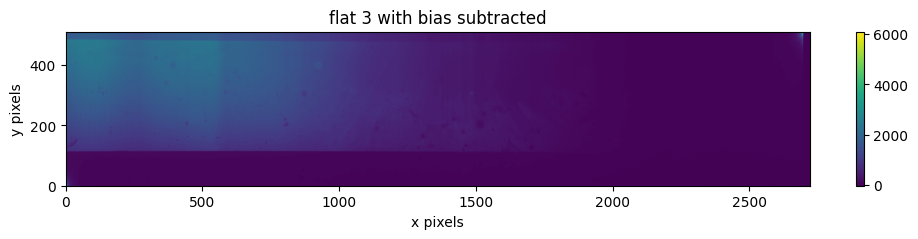

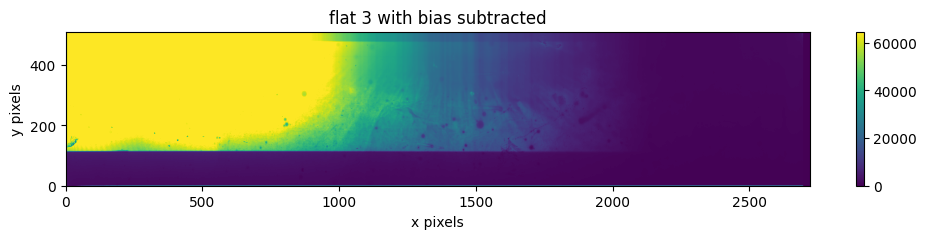

In [338]:
vmin=None
vmax=None
norm=None

#uncomment if want to plot all of the flats with bias subtracted
# for i, flat in enumerate(flat_data):
#     plot_fits(
#         flat, vmin=None, vmax=None, title=f'flat {i} with bias subtracted', norm=norm
#               )

#One example of good and too much saturation respectively
plot_fits(
    flat_data[3], vmin=None, vmax=None, title='flat 3 with bias subtracted', norm=norm
          )
plot_fits(
    flat_data[15], vmin=None, vmax=None, title='flat 3 with bias subtracted', norm=norm
          )


(23, 512, 2720)
(512, 2720)


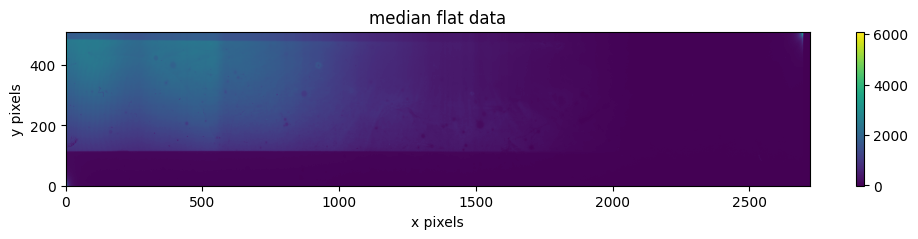

In [339]:
#indices of flats without significant saturation:
usable_flats_idxs = np.array([0, 2, 3, 5, 9, 10, 11, 12, 16, 19, 20, 21])

#Now get the median of the usable flats
flat_data = np.array(flat_data)
print(flat_data.shape)
print(np.median(flat_data, axis = 0).shape)
median_flat_data = np.median(flat_data, axis = 0)

#make a quick plot to again see what we're dealing with
plot_fits(
    median_flat_data, vmin=None, vmax=None, title='median flat data', norm=None
          )

/tmp/ipykernel_5647/762577328.py:3: RuntimeWarning: divide by zero encountered in divide
  source_darkflat_adj = (source_dark_adj)/(median_flat_data)
/tmp/ipykernel_5647/762577328.py:3: RuntimeWarning: invalid value encountered in divide
  source_darkflat_adj = (source_dark_adj)/(median_flat_data)
/tmp/ipykernel_5647/762577328.py:4: RuntimeWarning: divide by zero encountered in divide
  cal_darkflat_adj = (cal_dark_adj)/(median_flat_data)
/tmp/ipykernel_5647/762577328.py:4: RuntimeWarning: invalid value encountered in divide
  cal_darkflat_adj = (cal_dark_adj)/(median_flat_data)


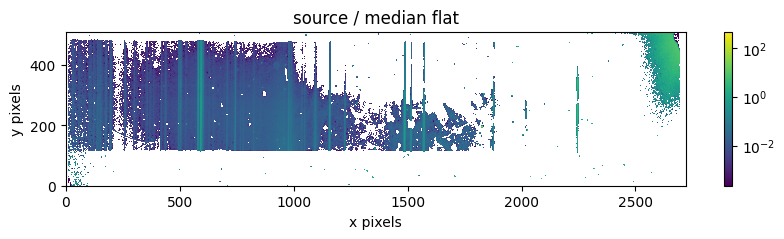

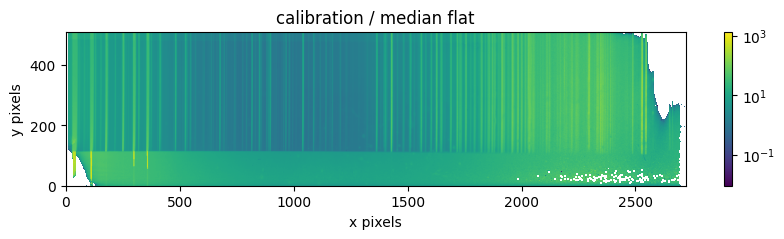

In [408]:
#adjusting for (dividing by) the flat data:
plt.rcParams['figure.figsize'] = (10, 2)
source_darkflat_adj = (source_dark_adj)/(median_flat_data)
cal_darkflat_adj = (cal_dark_adj)/(median_flat_data)
# norm = SymLogNorm(linthresh=0.03)
norm = 'log'
# norm = None

plot_fits(
    source_darkflat_adj, vmin=None, vmax=None, title='source / median flat', norm=norm
          )
plot_fits(
    cal_darkflat_adj, vmin=None, vmax=None, title='calibration / median flat', norm=norm
          )

## Part 3. Wavelength calibration

### Part 3.1 2D to 1D arc spectrum

(1798,)


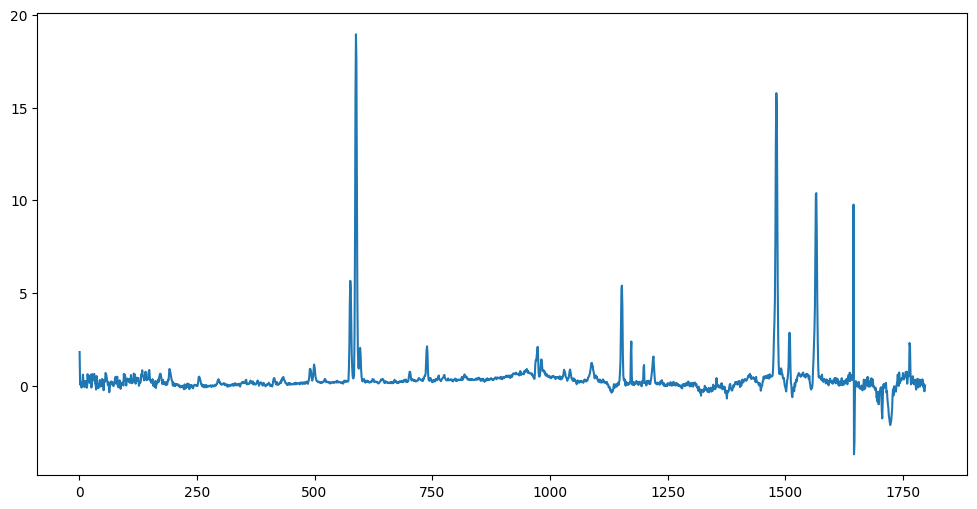

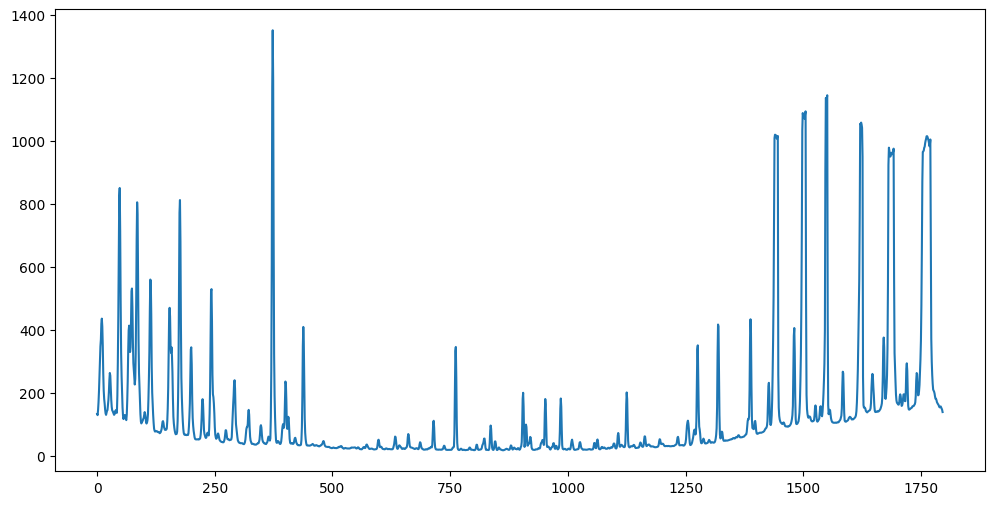

In [410]:
cleaned_source_spectrum = np.sum(source_darkflat_adj[180:200, 2:1800], axis = 0)
plt.rcParams['figure.figsize'] = (12, 6)
cleaned_cal_spectrum = np.sum(cal_darkflat_adj[180:200, 2:1800], axis=0)

#apparently the calibration spectrum is backward compared to the cuar file, so we need to reverse it
#NOTE: I need to try to find better evidence of the above
cleaned_cal_spectrum = cleaned_cal_spectrum[::-1]

print(cleaned_cal_spectrum.shape)
plt.plot(cleaned_source_spectrum)
plt.show()
plt.plot(cleaned_cal_spectrum)

Plotting the cuar file, we can see it spans far more pixels than our calibration file, making the task of matching peaks very tough:


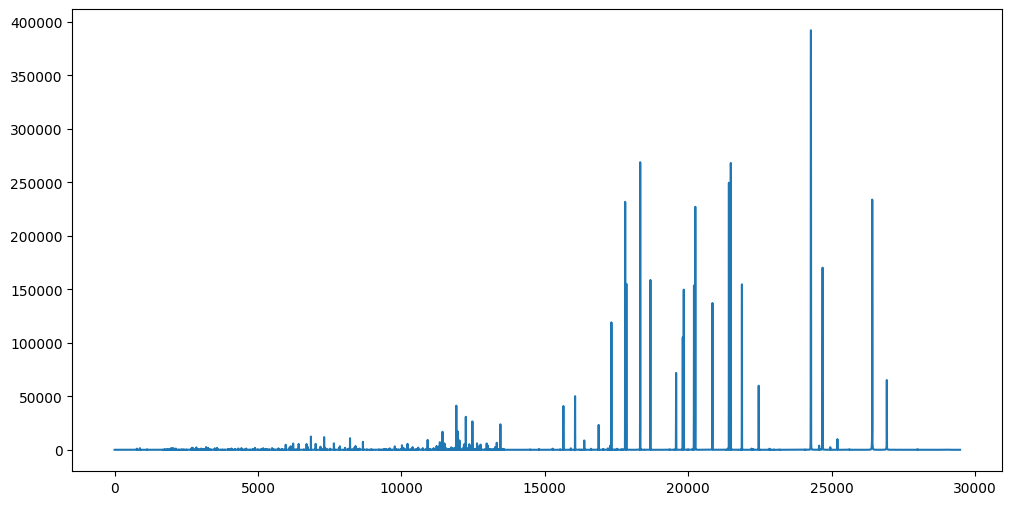

In [342]:
plt.plot(cuar_data)

### Part 3.2 Identifying lines using the cuar file

Note this part is super tough to simply try by eye, but there are a few things to make this section easier.

1. The calibration file was taken in the visible.
2. examining the header of the calibration file shows the number of angstroms per pixel is about 1.73, so we can get a better sense of what range of the cuar.fits file to be looking at.

In [343]:
cuar_file_path = './fit_files/cuar.fits'
cuar_data, cuar_file = fits_to_data(cuar_file_path)
print(repr(cuar_file[0].header))


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                29480 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2004-09-03T22:14:15' / Date FITS file was generated                  
IRAF-TLM= '15:14:15 (03/09/2004)' / Time of last modification                   
OBJECT  = '3250A   '           / Name of the object observed                    
OBSERVAT= 'KPNO              '  /  observatory                                  
OBSERVER= 'Willmarth         '  /  observers                                    
PROPID  = 'T&E               '  /  observing proposal ID                        
EXPTIME =             100.14

In [344]:

print(repr(calibration_file[0].header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'lampecuar'          / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =                 5.00  / Temps d'exposition (sec)                      
DARKTIME=                 5.00  / Temps total ecoule (sec)                      
IMAGETYP= 'comp    '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:19:

It is possible to pick out individual pixels and determine what the corresponding wavelength is. Like below. Though it makes more sense for matching purposes to convert the whole axis of the cuar file to wavelength instead of pixels.

In [345]:
from astropy.wcs import WCS
import astropy.units as u


# Replace 'spectrum.fits' with the path to your FITS file
filename = './fit_files/cuar.fits'
with fits.open(filename) as hdul:
    header = hdul[0].header  # Assuming the WCS is in the primary header
    # Create a WCS object from the header
    wcs = WCS(header)

pixel_index = 25000
pixels = np.array([[pixel_index]])  # 2D array with one coordinate pair
wavelength = wcs.all_pix2world(pixels, 0)

print(f"Pixel {pixel_index} corresponds to a wavelength of {wavelength[0, 0]:.3f} Angstroms")


Pixel 25000 corresponds to a wavelength of 9303.565 Angstroms


In [346]:
npix = header['NAXIS1']

# Create an array of pixel indices.
# If you are using 0-indexing (Python style), use np.arange(npix).
# The WCS functions expect a 2D array with shape (N, ndim), so we reshape.
pixel_indices = np.arange(npix)[:, np.newaxis]

# Convert all pixel indices to world coordinates (wavelengths)
# Pass the origin as a positional argument (0 for 0-indexed)
wavelengths = wcs.all_pix2world(pixel_indices, 0)  # returns an array of shape (npix, 1)

# Flatten the result to get a 1D array of wavelengths
wavelengths = wavelengths.flatten()

# Optionally, attach units if desired (the header indicates Angstroms)
wavelengths = wavelengths * u.Angstrom

print(wavelengths)

[ 3053.56518555  3053.81518555  3054.06518555 ... 10422.81518555
 10423.06518555 10423.31518555] Angstrom


Now, plotting cuar as a function of wavelength in angstroms, things make a little be more sense

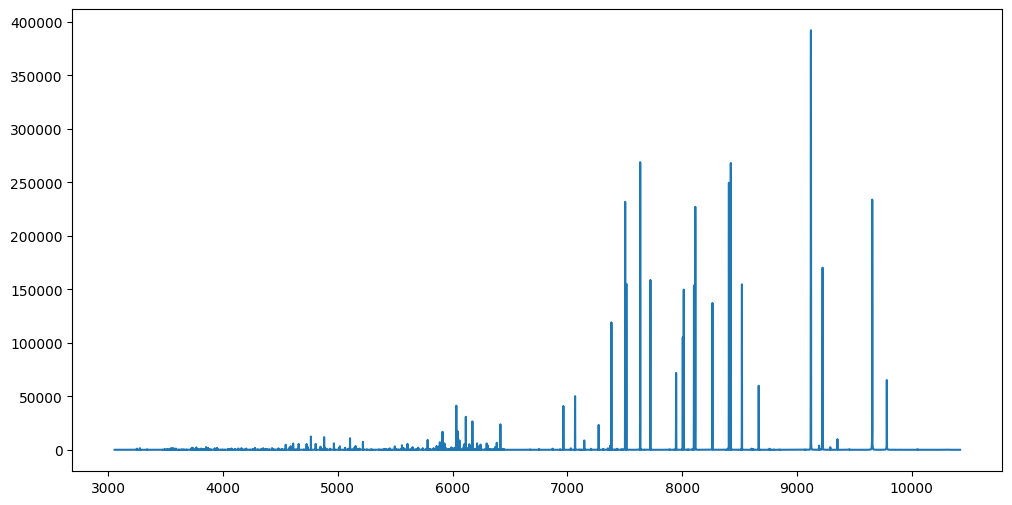

In [347]:
plt.plot(wavelengths, cuar_data)

Let's now try and label some of the peaks

One way we can do this is using scipy

[ 3054.06518555  3054.81518555  3055.81518555 ... 10419.06518555
 10421.31518555 10422.56518555] Angstrom


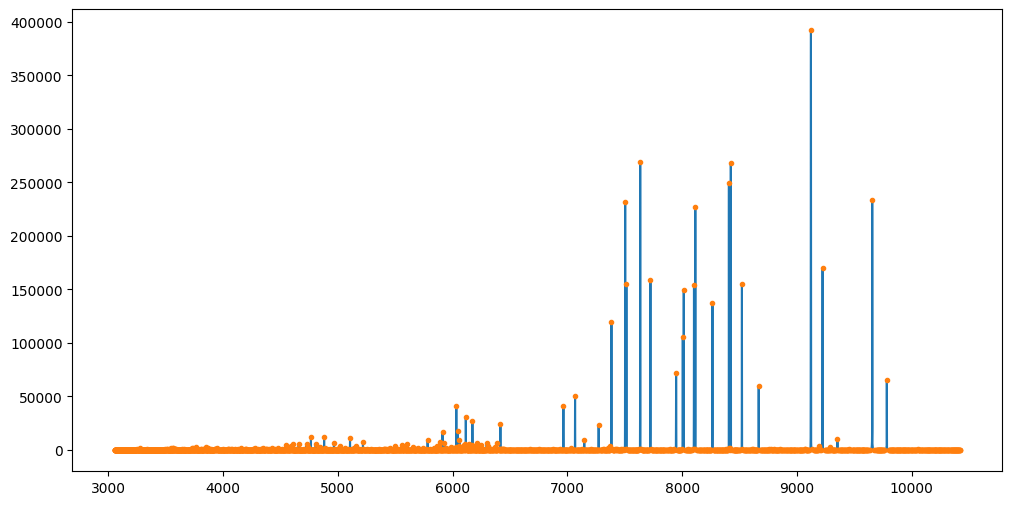

In [348]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(cuar_data)
print(wavelengths[peaks])

plt.plot(wavelengths, cuar_data)
plt.plot(wavelengths[peaks], cuar_data[peaks], ".", label='Detected Peaks')

Though this plots a bunch of useless points along the bottom of the array. Instead we can find the extrema of relative extrema

[3247.56518555 3274.06518555 3545.81518555 3559.56518555 3561.06518555
 3576.56518555 3588.31518555 3729.31518555 3737.81518555 3765.31518555
 3809.56518555 3850.56518555 3868.56518555 3925.81518555 3928.56518555
 3946.06518555 3949.06518555 4072.06518555 4131.81518555 4158.56518555
 4200.81518555 4277.56518555 4348.06518555 4426.06518555 4481.81518555
 4545.06518555 4579.31518555 4589.81518555 4609.56518555 4657.81518555
 4726.81518555 4732.06518555 4735.81518555 4764.81518555 4806.06518555
 4847.81518555 4879.81518555 4889.06518555 4933.06518555 4965.06518555
 5009.31518555 5017.06518555 5062.06518555 5105.56518555 5141.81518555
 5145.31518555 5153.31518555 5162.31518555 5187.81518555 5218.31518555
 5451.56518555 5495.81518555 5558.56518555 5572.56518555 5606.56518555
 5650.56518555 5700.06518555 5739.56518555 5782.06518555 5834.31518555
 5860.31518555 5882.56518555 5888.56518555 5912.06518555 5928.81518555
 5942.56518555 5987.31518555 5999.06518555 6013.56518555 6025.06518555
 6032.

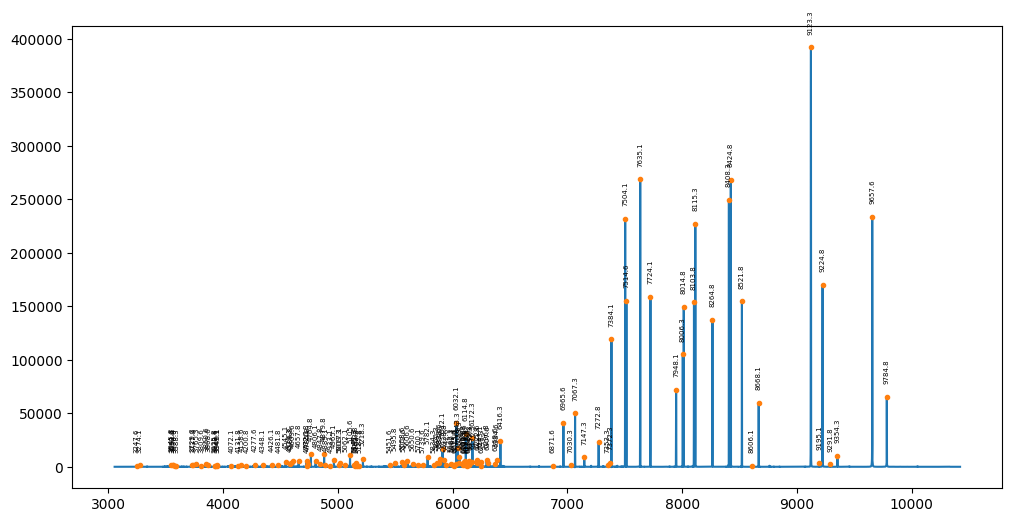

In [349]:
from scipy.signal import argrelextrema
from scipy.signal import argrelmax

#this does the same as find_peaks
#idxs = argrelmax(cuar_data)

#try this instead
idxs = argrelextrema(cuar_data, np.greater, order=5)[0]
max_cuar_vals = cuar_data[idxs]

rel_max_cuar_idxs = idxs[cuar_data[idxs] > 1000]
peak_wavelengths = np.array(wavelengths[rel_max_cuar_idxs])
peak_intensities = np.array(cuar_data[rel_max_cuar_idxs])
print(peak_wavelengths)
print(peak_intensities)


plt.plot(wavelengths, cuar_data)
plt.plot(peak_wavelengths, peak_intensities, '.')
for i, wavelength in enumerate(peak_wavelengths):
    plt.annotate(f"{peak_wavelengths[i]:.1f}", (peak_wavelengths[i], peak_intensities[i]),
                 textcoords='offset points', xytext=(0,10), ha='center', rotation=90, fontsize=5)


Let's trim this a bit to the range we expect

[3247.56518555 3274.06518555 3545.81518555 3559.56518555 3561.06518555
 3576.56518555 3588.31518555 3729.31518555 3737.81518555 3765.31518555
 3809.56518555 3850.56518555 3868.56518555 3925.81518555 3928.56518555
 3946.06518555 3949.06518555 4072.06518555 4131.81518555 4158.56518555
 4200.81518555 4277.56518555 4348.06518555 4426.06518555 4481.81518555
 4545.06518555 4579.31518555 4589.81518555 4609.56518555 4657.81518555
 4726.81518555 4732.06518555 4735.81518555 4764.81518555 4806.06518555
 4847.81518555 4879.81518555 4889.06518555 4933.06518555 4965.06518555
 5009.31518555 5017.06518555 5062.06518555 5105.56518555 5141.81518555
 5145.31518555 5153.31518555 5162.31518555 5187.81518555 5218.31518555]


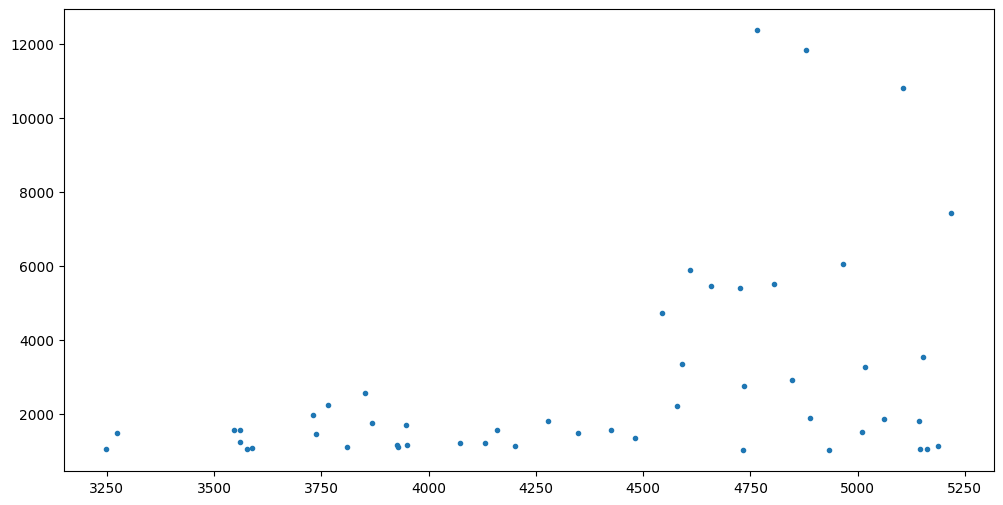

In [350]:
trimmed_peak_wavelengths = peak_wavelengths[:50]
trimmed_peak_intensities = peak_intensities[:50]
print(trimmed_peak_wavelengths)
plt.plot(trimmed_peak_wavelengths, trimmed_peak_intensities, '.')

#### The above is slightly useless since we lose information about the edges of the sample chosen

Let's save both the calibration and the cuar file in high res and try and match by eye using powerpoint

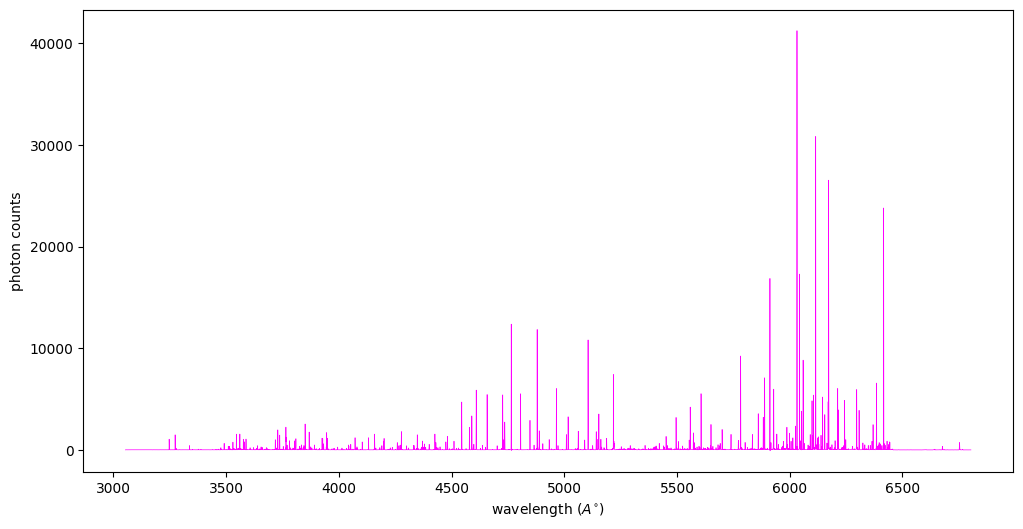

In [351]:
yrange=15000
cuar_data1 = cuar_data[:yrange]
plt.plot(wavelengths[:yrange], cuar_data1, linewidth=0.5, color='magenta')
plt.xlabel('wavelength $(A^{\circ})$')
plt.ylabel('photon counts')
plt.savefig('cuar_data.png', dpi = 700, format = 'png', bbox_inches='tight')
plt.show()

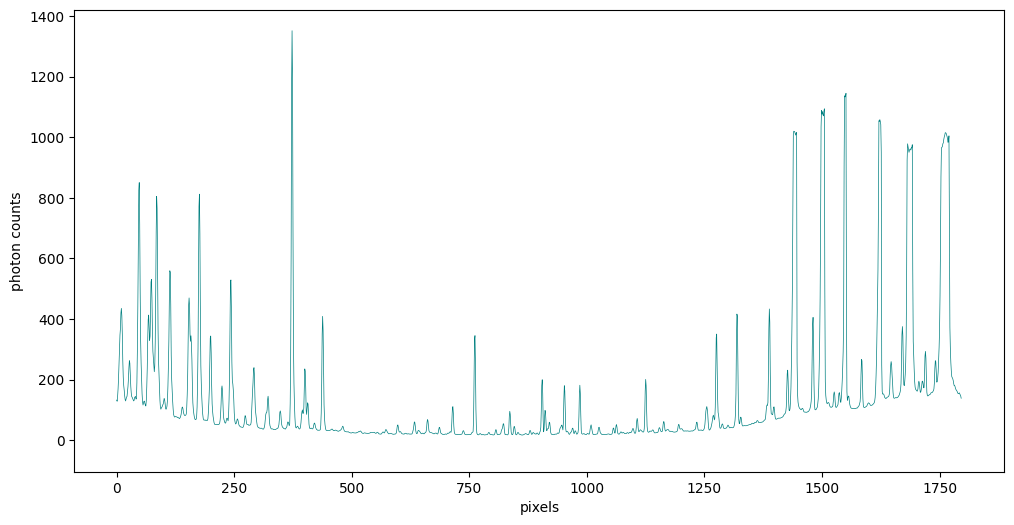

In [352]:
plt.plot(cleaned_cal_spectrum, linewidth=0.5, color='teal')
plt.xlabel('pixels')
plt.ylabel('photon counts')
plt.savefig('cleaned_cal_spectrum.png', dpi=700, format='png', bbox_inches='tight')
plt.show()

#### Overlaying the images on one another yields the following result

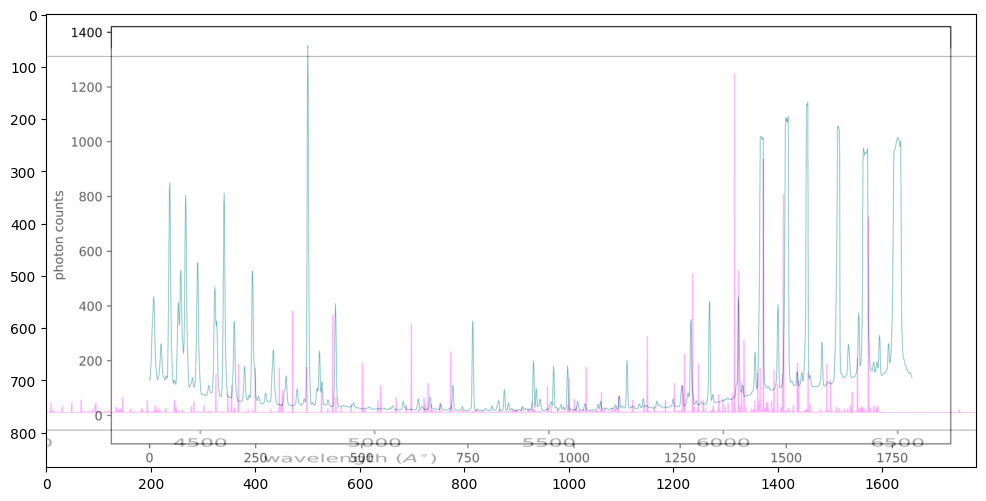

In [353]:
import matplotlib.image as mpimg
cal_by_eye_img = mpimg.imread('calbyeye.png')
plt.imshow(cal_by_eye_img)
plt.show()

In [354]:
### We manually pick out several peaks that seem to line up on both plots using the wavelength information displayed on the cuar plot above
#adding to each array by comparing the two plots by eye (the ordering goes from left to right)
cuar_peaks = np.array([4545.1, 4609.6, 4726.8, 4806.1, 4879.8, 5062.1, 5153.3, 5218.3, 5495.8, 5558.6, 5606.6, 5739.6, 5912.1, 6032.1, 6114.8])
calibration_peaks = np.array([154, 200, 292, 373, 438, 598, 661, 715, 905, 952, 985, 1107, 1276, 1388, 1440])

So now plotting the trimmed cuar file along with peaks picked out, we find the following

Making sure also, to only show the highest peaks to not convolute the image.

However, it's a good  idea to show pixel locations on the calibration file also to best be able to match wavelength values to pixels.

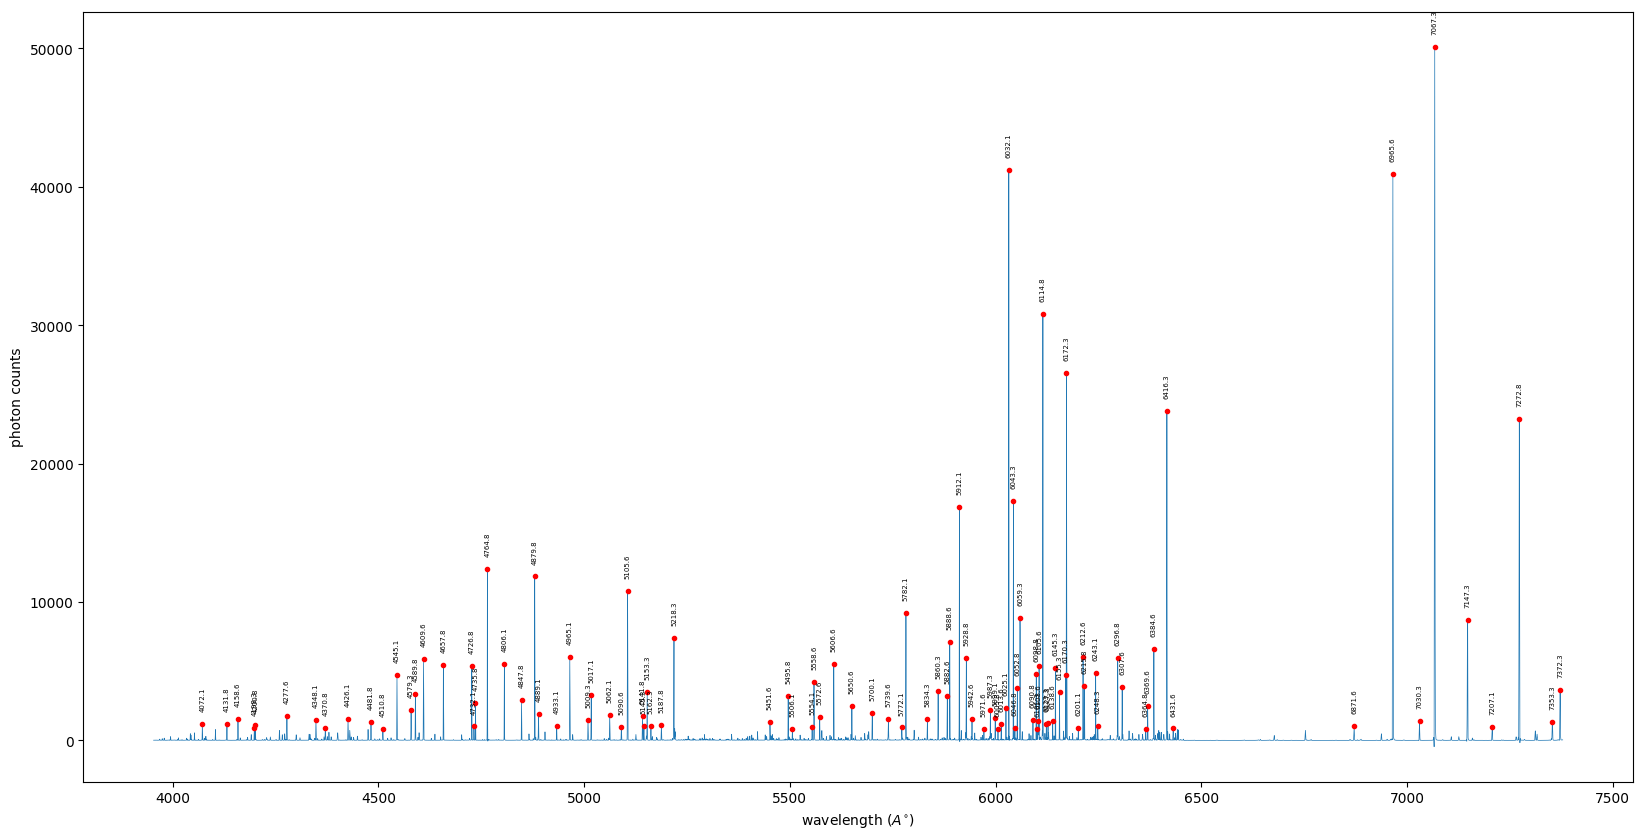

In [430]:
plt.rcParams['figure.figsize'] = (20, 10)
xmin = 3600
xmax = 17300
cuar_data2 = cuar_data[xmin:xmax]
wavelengths_segment = wavelengths[xmin:xmax]

cuar_idxs = argrelextrema(cuar_data2, np.greater, order=5)[0]
max_cuar_vals = cuar_data[cuar_idxs]

rel_max_cuar_idxs = cuar_idxs[cuar_data2[cuar_idxs] > 800]
peak_wavelengths = np.array(wavelengths_segment[rel_max_cuar_idxs])
peak_intensities = np.array(cuar_data2[rel_max_cuar_idxs])
# print(peak_wavelengths)
# print(peak_intensities)

plt.plot(wavelengths_segment, cuar_data2, linewidth=0.5)
plt.plot(peak_wavelengths, peak_intensities,'.', color = 'red')
plt.xlabel('wavelength ($A^{\circ}$)')
plt.ylabel('photon counts')
for i, wavelength in enumerate(peak_wavelengths):
    plt.annotate(f"{peak_wavelengths[i]:.1f}", (peak_wavelengths[i], peak_intensities[i]),
                 textcoords='offset points', xytext=(0,10), ha='center', rotation=90, fontsize=5)
plt.savefig('cuar_display_peaks.png', dpi=800, format='png', bbox_inches='tight')

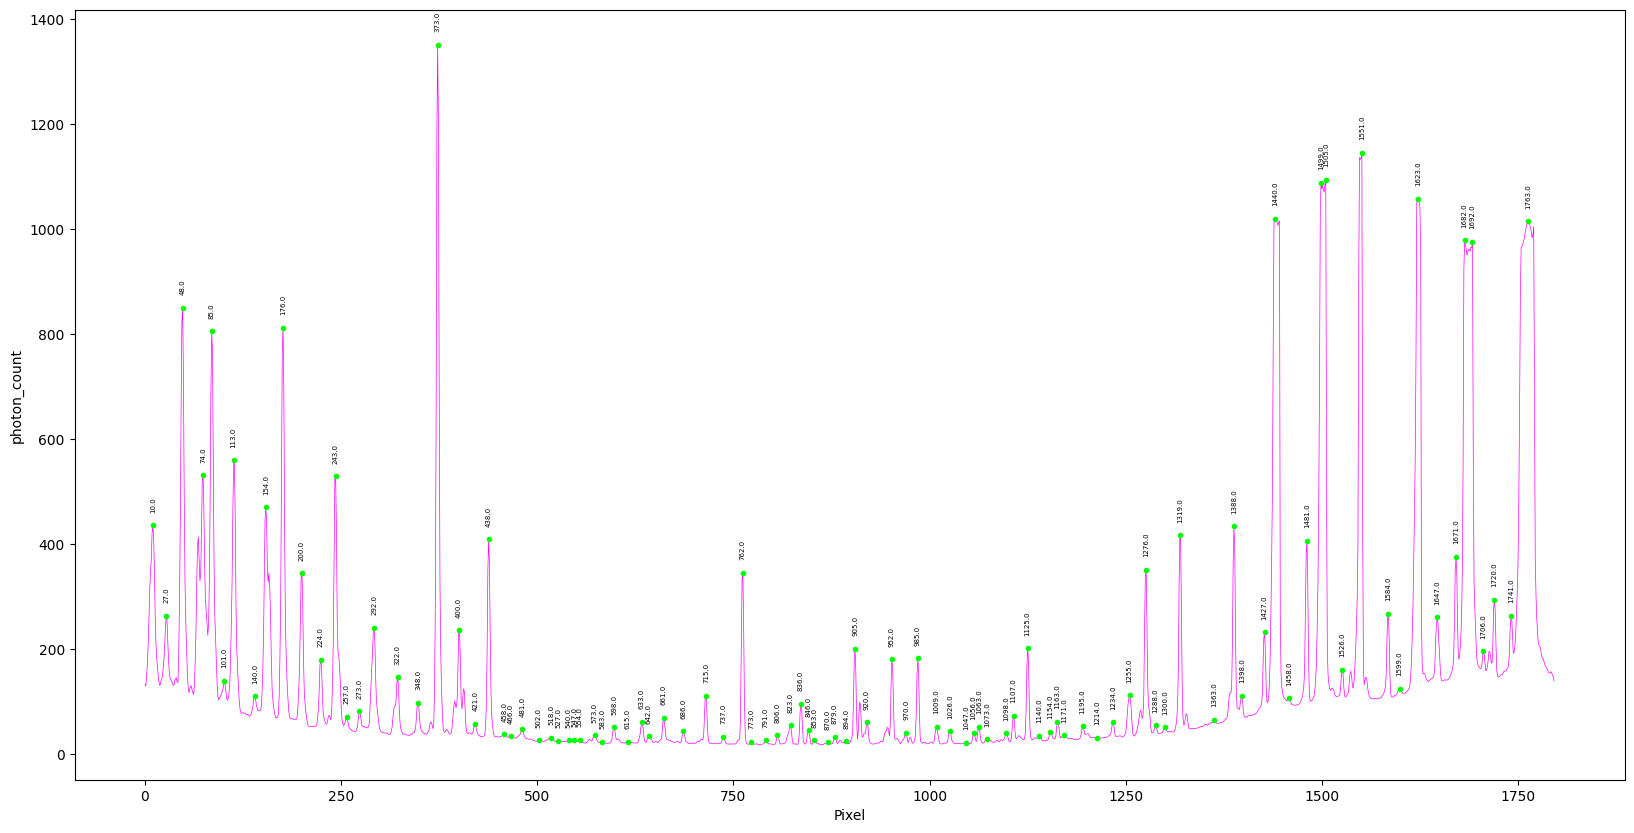

In [436]:
calibration_idxs = argrelextrema(cleaned_cal_spectrum, np.greater, order=5)[0]
max_cal_vals = cleaned_cal_spectrum[calibration_idxs]

plt.plot(cleaned_cal_spectrum, color = 'magenta', linewidth=0.5)
plt.plot(calibration_idxs, max_cal_vals,'.', color = 'lime')
plt.xlabel('Pixel')
plt.ylabel('photon_count')
for i, idx in enumerate(calibration_idxs):
    plt.annotate(f"{calibration_idxs[i]:.1f}", (calibration_idxs[i], max_cal_vals[i]),
                 textcoords='offset points', xytext=(0,10), ha='center', rotation=90, fontsize=5)
plt.savefig('calibration_with_peaks.png', dpi=800, format='png', bbox_inches='tight')

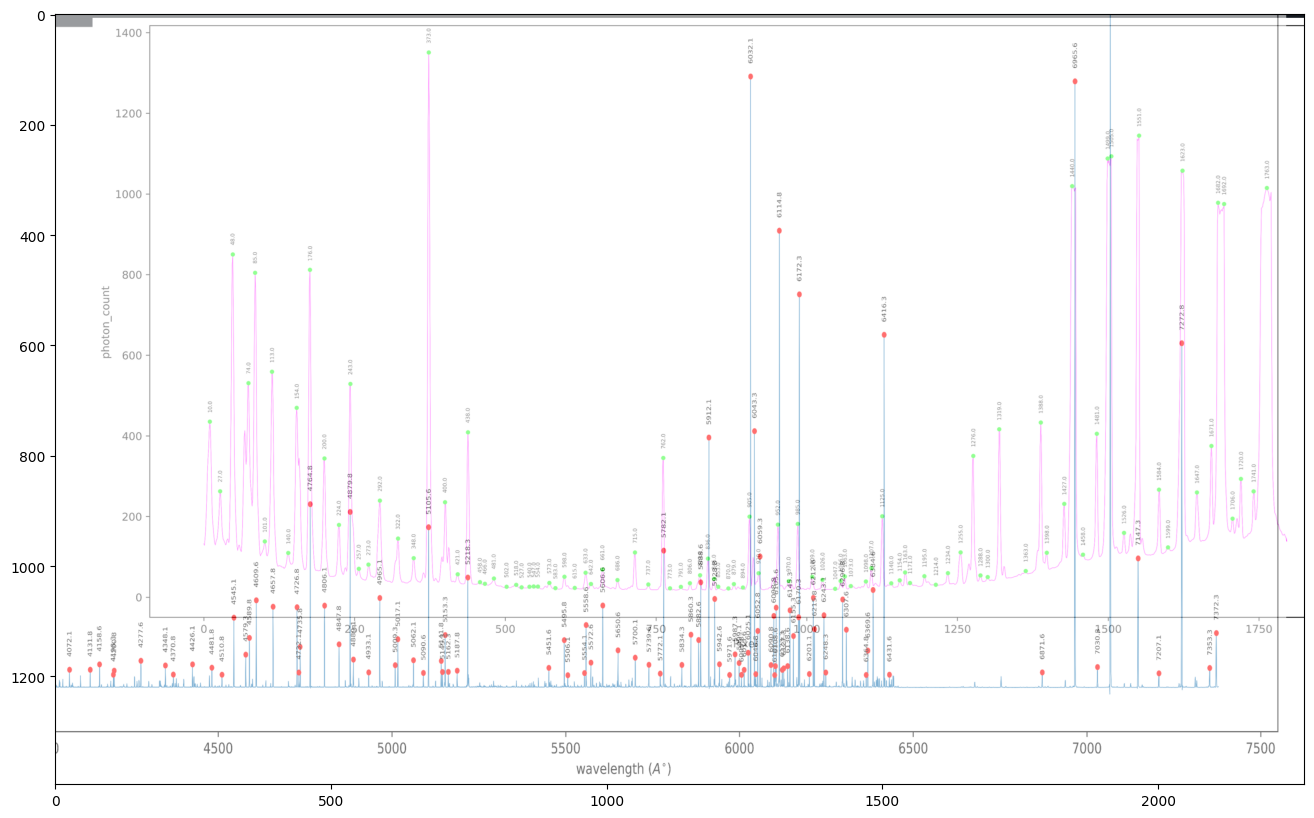

In [437]:
import matplotlib.image as mpimg
cal_by_eye_img = mpimg.imread('calbyeye2.png')
plt.imshow(cal_by_eye_img)
plt.show()

### We manually pick out several peaks that seem to line up on both plots using the wavelength information displayed on the cuar plot above

As we can see from the linear fit and the residuals, the relationship is definitely not linear. Trying a Chebyshev should result in a better fit.

In [449]:
from scipy.optimize import curve_fit
#adding to each array by comparing the two plots by eye (the ordering goes from left to right)
# cuar_peaks = np.array([4545.1, 4609.6, 4726.8, 4806.1, 4879.8, 5062.1, 5153.3, 5218.3, 5495.8, 5558.6, 5606.6, 5739.6, 5912.1, 6032.1, 6114.8])
# calibration_peaks = np.array([154, 200, 292, 373, 438, 598, 661, 715, 905, 952, 985, 1107, 1276, 1388, 1440])

cuar_peaks = np.array([4545.1, 4609.6, 4657.8, 4726.8, 4764.8, 4806.1, 4847.8, 4879.8, 4933.1, 4965.1, 5017.1, 5062, 5105.6, 5218.3, 5496.8, 5558.6, 5606.6, 5650.6, 5700.1, 5739.6, 5782.1, 5912.1, 6032.1, 6059.3, 6114.8, 6172.3, 6243.1, 6384.6, 6416.3, 6871.6, 6965.6, 7030.8, 7147.3, 7207.1, 7272.8, 7353.3, 7372.3])
calibration_peaks = np.array([48, 85, 113, 154, 176, 200, 224, 243, 273, 292, 322, 348, 373, 438, 598, 633, 661, 686, 715, 737, 762, 836,  905, 920, 952, 985, 1026, 1107, 1125, 1388, 1440, 1481, 1551, 1584, 1623, 1671, 1687])

In [450]:
def fit_fun(x, m, b):
    return m*x + b

fitp, cov = curve_fit(fit_fun, calibration_peaks, cuar_peaks)
residuals = cuar_peaks - fit_fun(calibration_peaks, fitp[0], fitp[1])

1.226610767779614
[[ 1.30573907e-06 -1.00090193e-03]
 [-1.00090193e-03  1.10838605e+00]]


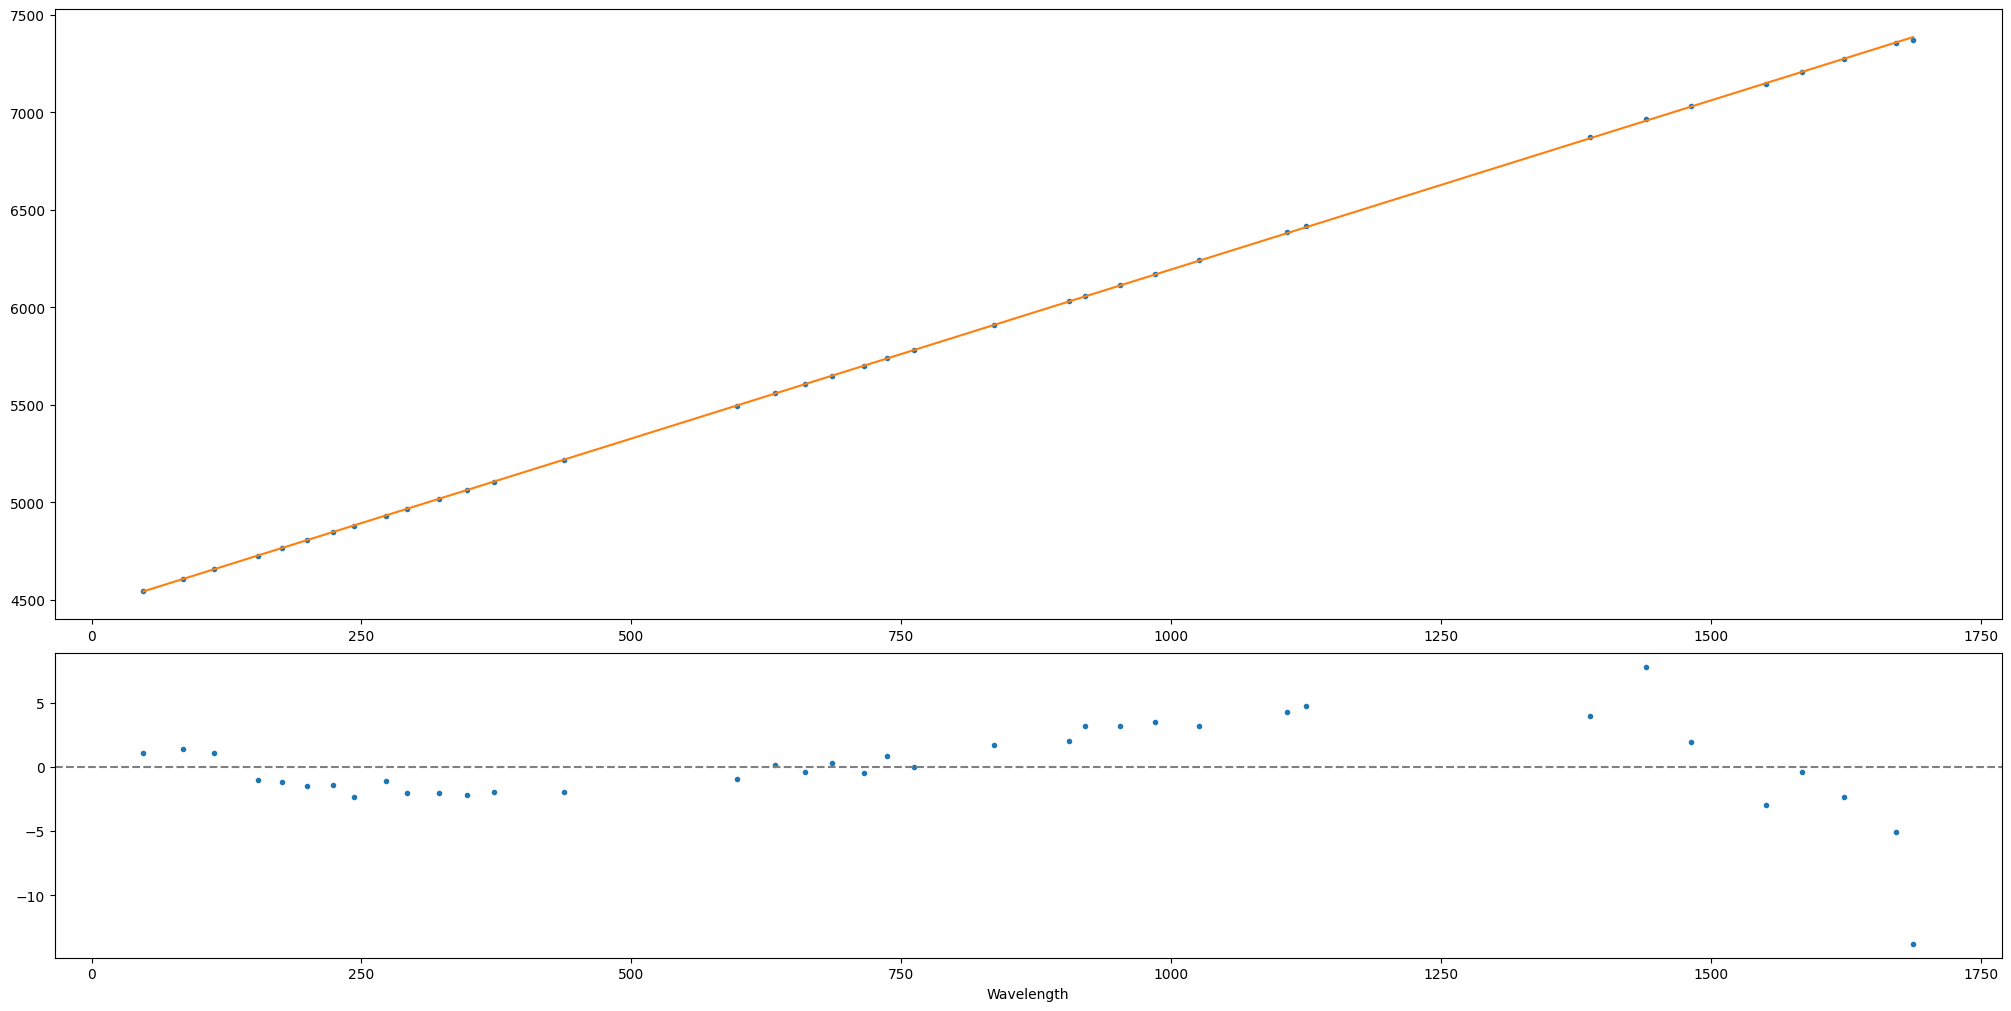

In [451]:

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, layout='constrained')
ax1.plot(calibration_peaks, cuar_peaks, '.')
ax1.plot(calibration_peaks, fit_fun(calibration_peaks, fitp[0], fitp[1]))
ax2.plot(calibration_peaks, residuals, '.')
ax2.axhline(y=0, color='grey', linestyle='--')
ax2.set_xlabel('Wavelength')
print(fit_params[0])
print(cov)

Text(0.5, 0, 'Wavelength')

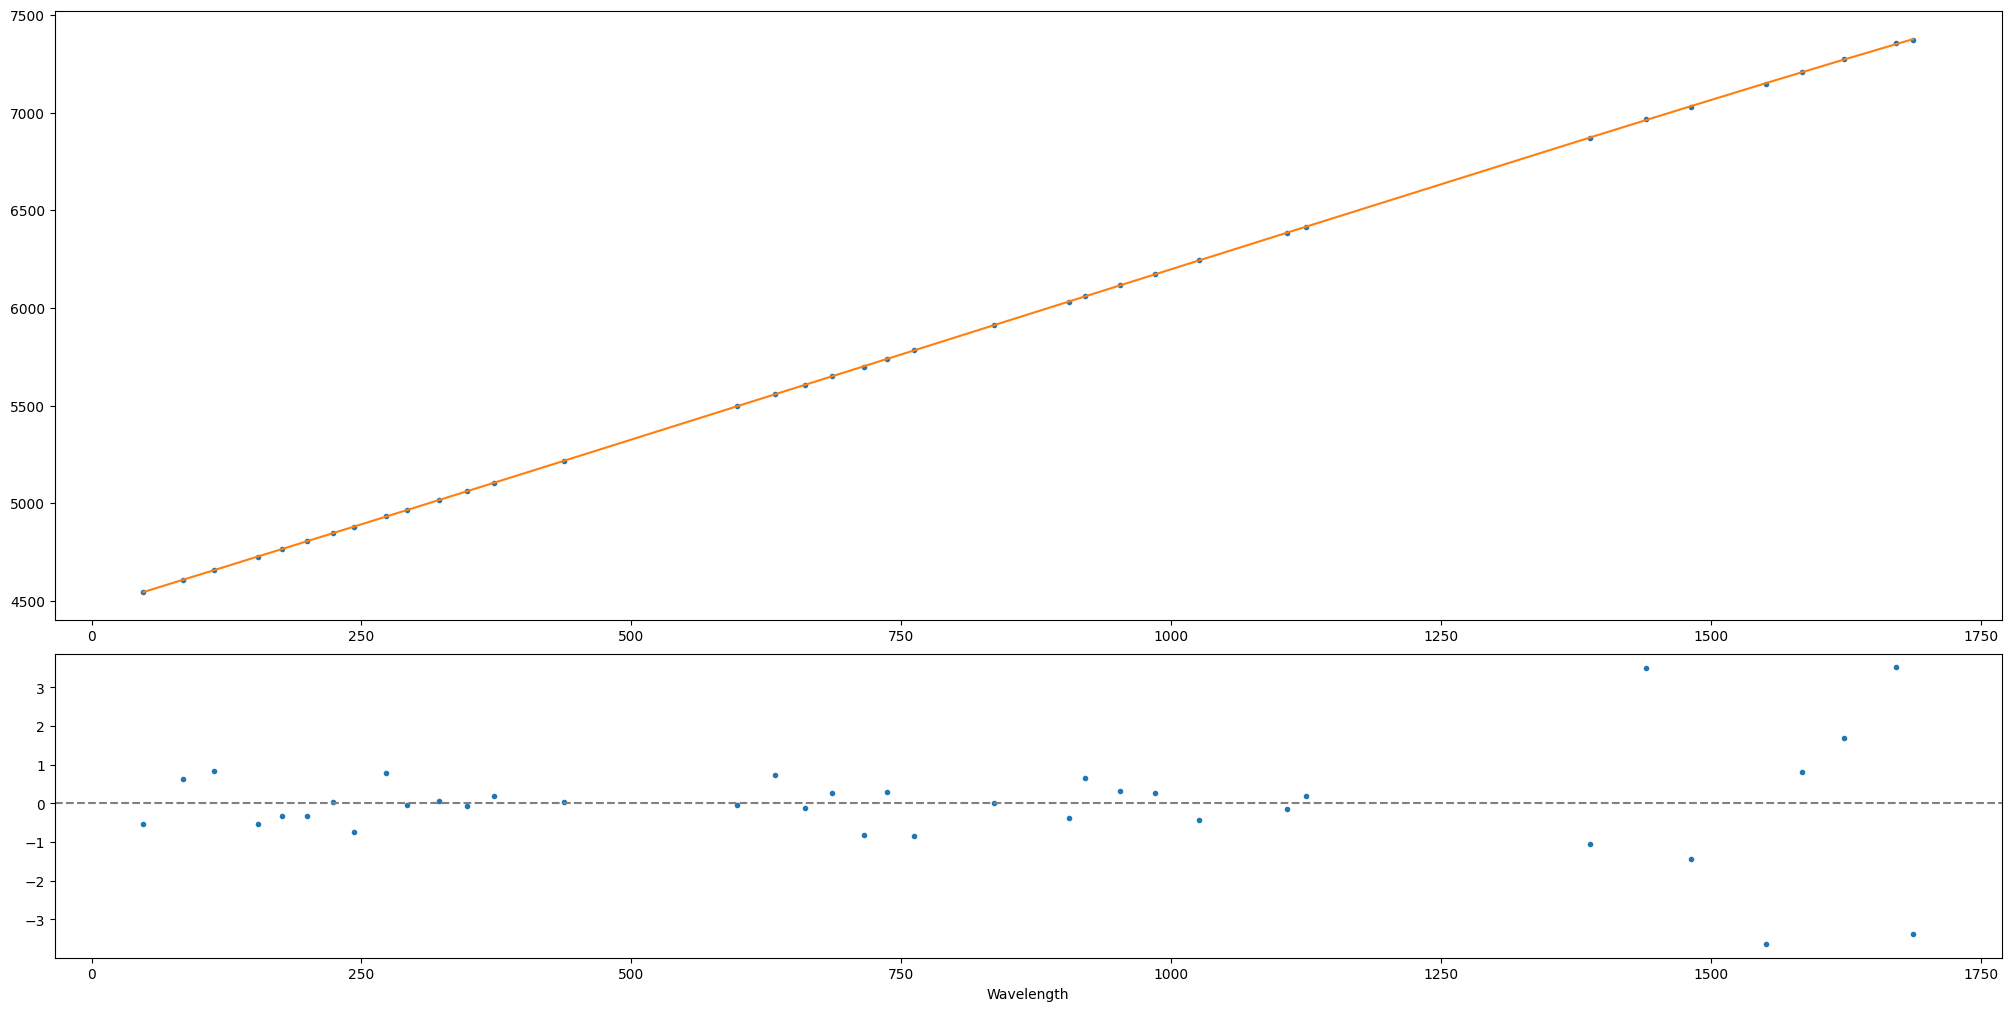

In [461]:
from numpy.polynomial.chebyshev import Chebyshev

#note we can do this quickly using the built in fit function in Numpy
#order 6 seems to give the best fit
cheb_fit = Chebyshev.fit(calibration_peaks, cuar_peaks, 6)
cheb_fit_vals = cheb_fit(calibration_peaks)
cheb_residuals = cuar_peaks - cheb_fit_vals


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, layout='constrained')
ax1.plot(calibration_peaks, cuar_peaks, '.')
ax1.plot(calibration_peaks, cheb_fit_vals)
ax2.plot(calibration_peaks, cheb_residuals, '.')
ax2.axhline(y=0, color='grey', linestyle='--')
ax2.set_xlabel('Wavelength')

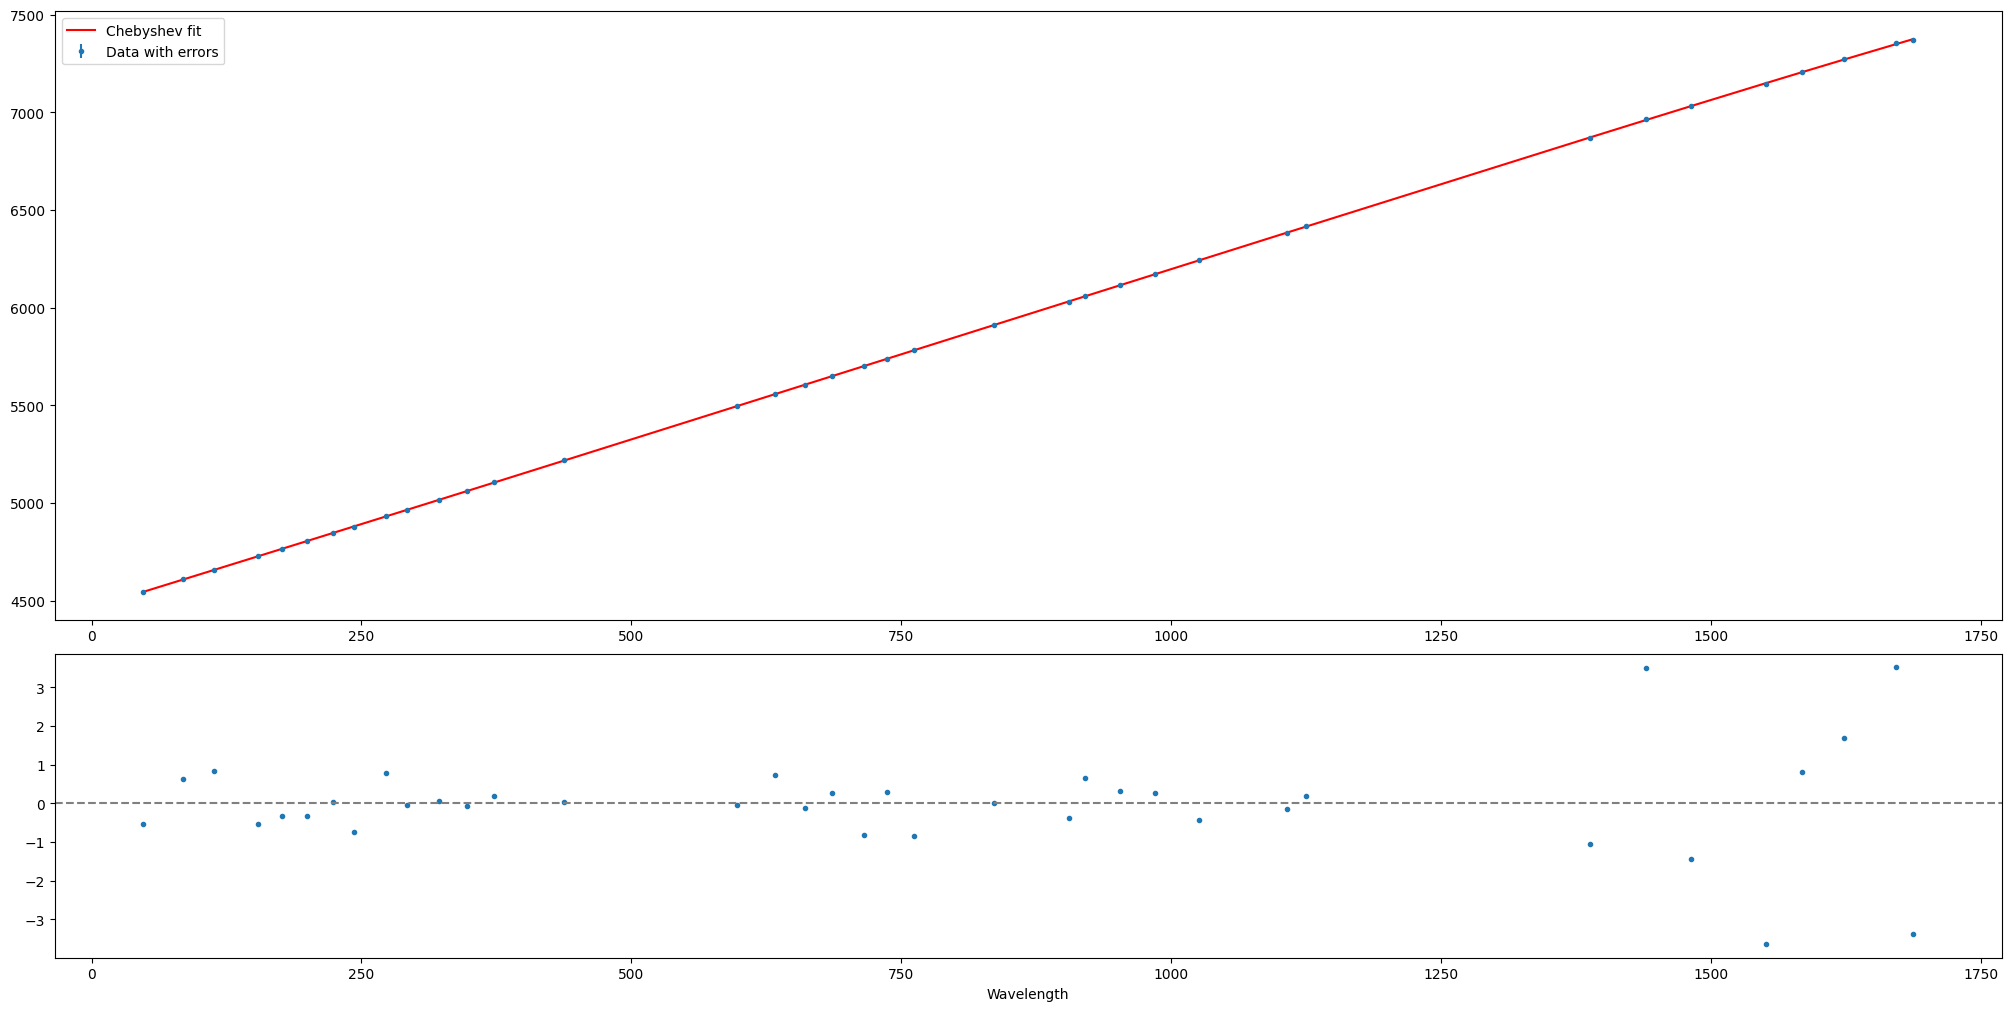

Optimal coefficients: [ 4.46356809e+03  1.70876802e+00  6.96282840e-06  2.47857652e-08
 -2.17651765e-11  7.18652170e-15 -8.77184560e-19]
Covariance matrix:
 [[ 5.74306474e+00 -8.15662368e-02  1.87775134e-04 -1.91200691e-07
   9.55949935e-11 -2.29939448e-14  2.12596827e-18]
 [-8.15662368e-02  1.32109037e-03 -3.25074928e-06  3.43560649e-09
  -1.75807105e-12  4.29537777e-16 -4.01579381e-20]
 [ 1.87775134e-04 -3.25074928e-06  8.34682902e-09 -9.05781968e-12
   4.71805767e-15 -1.16734644e-18  1.10160601e-22]
 [-1.91200691e-07  3.43560649e-09 -9.05781968e-12  1.00104382e-14
  -5.28407884e-18  1.32057145e-21 -1.25593841e-25]
 [ 9.55949935e-11 -1.75807105e-12  4.71805767e-15 -5.28407884e-18
   2.81808677e-21 -7.10007215e-25  6.79650930e-29]
 [-2.29939448e-14  4.29537777e-16 -1.16734644e-18  1.32057145e-21
  -7.10007215e-25  1.80063004e-28 -1.73297139e-32]
 [ 2.12596827e-18 -4.01579381e-20  1.10160601e-22 -1.25593841e-25
   6.79650930e-29 -1.73297139e-32  1.67542338e-36]]


In [462]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.polynomial.chebyshev import chebval, chebvander

#Define the Chebyshev model function.
#The function takes x and an arbitrary number of coefficients.
def chebyshev_model(x, *coeffs):
    return chebval(x, coeffs)

#Set the polynomial degree (for degree 6, we need 7 coefficients) => We know degree 6 works the best from above
degree = 6
n_params = degree + 1

#Provide an initial guess for the parameters (here, just ones)
p0 = np.ones(n_params)

#Use curve_fit to fit the Chebyshev model.
popt, pcov = curve_fit(chebyshev_model, calibration_peaks, cuar_peaks, p0=p0)

#popt are the optimal coefficients; pcov is their covariance matrix.
#Evaluate the fitted model at the calibration peaks.
cheb_fit_vals = chebyshev_model(calibration_peaks, *popt)

#To propagate the covariance into errors on the fitted values:
#For a model f(x) = sum_i c_i * T_i(x), the partial derivative with respect to c_i is T_i(x).
#We can compute the Chebyshev Vandermonde matrix, which gives the basis functions at each x.
V = chebvander(calibration_peaks, degree)  # shape (N, n_params)

#The error (standard deviation) on f(x) at each x is:
#sigma_f(x) = sqrt( v(x)^T * pcov * v(x) )
#We compute this vectorized over all x.
fit_errors = np.sqrt(np.sum(V * (V @ pcov), axis=1))

#Plot the data, the fitted Chebyshev polynomial, and error bars on the fit.
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, layout='constrained')

#Top plot: data with fitted curve and error bars.
ax1.errorbar(calibration_peaks, cuar_peaks, yerr=fit_errors, fmt='.', label='Data with errors')
ax1.plot(calibration_peaks, cheb_fit_vals, 'r-', label='Chebyshev fit')
ax1.legend()

#Bottom plot: residuals.
cheb_residuals = cuar_peaks - cheb_fit_vals
ax2.plot(calibration_peaks, cheb_residuals, '.')
ax2.axhline(y=0, color='grey', linestyle='--')
ax2.set_xlabel('Wavelength')

plt.show()

# Optionally, print the fit parameters and covariance:
print("Optimal coefficients:", popt)
print("Covariance matrix:\n", pcov)


### We should now be able to convert the pixel values of our source to waavelength values

(118,)
(118,)


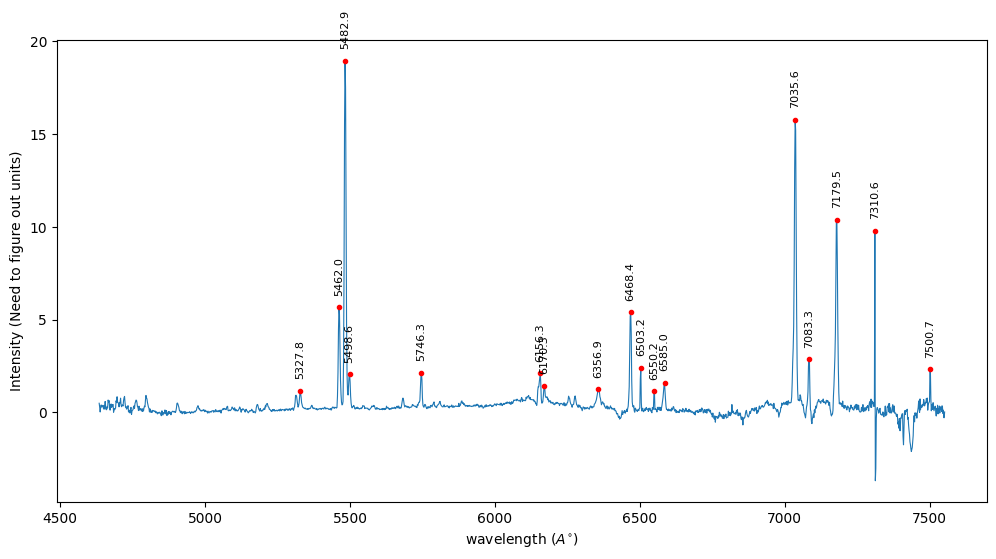

In [464]:
plt.rcParams['figure.figsize'] = (12, 6)

#pltting the cleaned source spectrum in the same y ranges as initially and in the x ranges that allow us to clearly see the defining spectral features
xmin=100
xmax=1800
cleaned_source_spectrum = np.sum(source_darkflat_adj[180:200, xmin:xmax], axis = 0)

#we need to flip this file since we did the same for the calibration file
# cleaned_source_spectrum = cleaned_source_spectrum[::-1]

#converting pixel values to wavelength:
pixel_array = np.arange(xmin, len(cleaned_source_spectrum)+xmin)
# print(pixel_array)

# source_wavelength_array = chebyshev_model(pixel_array, *popt)
source_wavelength_array = cheb_fit(pixel_array)
# print(source_wavelength_array)


"""-------"""
#selecting the most prominent peaks on the plot
source_idxs = argrelextrema(cleaned_source_spectrum, np.greater, order=5)[0]
source_vals = cleaned_source_spectrum[source_idxs]
print(source_idxs.shape)
print(source_vals.shape)

#pick out the most discernable peaks
max_source_idxs = source_idxs[cleaned_source_spectrum[source_idxs] > 1]
max_source_wavelengths = np.array(source_wavelength_array[max_source_idxs])
max_source_peaks = np.array(cleaned_source_spectrum[max_source_idxs])


plt.plot(source_wavelength_array, cleaned_source_spectrum, linewidth=0.8)
plt.plot(max_source_wavelengths, max_source_peaks, '.', color='red')
plt.xlabel('wavelength ($A^{\circ}$)')
plt.ylabel('Intensity (Need to figure out units)')
for i, idx in enumerate(max_source_wavelengths):
    plt.annotate(f"{max_source_wavelengths[i]:.1f}", (max_source_wavelengths[i], max_source_peaks[i]),
                 textcoords='offset points', xytext=(0,10), ha='center', rotation=90, fontsize=8)
plt.show()

Possible elements associated with the lines include Oxygen, Iron, Neon?

Line right at 5000 could be OIII

the lower two lines could correspnd to HeI or NII